In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from math import factorial

В ходе этой работы предстоит сделать следующие шаги:
-  Предобработать данные, заполнив пропущенные значения там, где это возможно, а так же удалить дубликаты при их наличии
-  Исследовать значения в датафреймах визуально, а именно:
    - частота встречаемости городов;
    - соотношение пользователей с подпиской и без подписки;
    - возраст пользователей;
    - расстояние, которое пользователь преодолел за одну поездку;
    - продолжительность поездок.
- Объеденить данные из трех датафреймов, а так же создать два новых и визуализировать информацию о расстоянии и времени поездок по параметру:
    - есть подписка
    - подписки нет
- Создать новый датафрейм с агрегированными данными о поездках для каждого пользователя за месяц, основываясь на данных из предыдущих функций, со значениями:
    - суммарное расстояние
    - количество поездок
    - суммарное время
    - выручка каждого пользователя 
- Проверить следующие гипотезы и ответить на вопрос:
    - Влияние подписки на время поездки
    - Является ли расстояние одной поездки в 3130 метров оптимальным с точки зрения износа самоката?
    - Выше ли помесячная выручка пользователей за месяц, относительно пользователей без подписки?
        - Какой тест использовать для проверки гипотезы, что обращения в техподдержку значительно снизилось после обновления серверов?
- Дополнительно:
    - Сколько нужно промокодов, чтобы минимум 100 существующих клиентов продлили подписку на второй месяц с 95% вероятностью?
    - Оценить вероятность с помощью аппроксимации, какова вероятность, что уведомления откроют не более 399.5тыс. пользователей при условии, что планируется отправить 1млн уведомлений?

####  Загрузка данных

In [2]:
try: 
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscription = pd.read_csv('/datasets/subscriptions_go.csv')
except:
        users = pd.read_csv('/Users/aleksandrfilippov/Documents/ipynb/users_go.csv')
        rides = pd.read_csv('/Users/aleksandrfilippov/Documents/ipynb/rides_go.csv')
        subscription = pd.read_csv('/Users/aleksandrfilippov/Documents/ipynb/subscriptions_go.csv')

In [3]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


Датафрейм состоит из следующих столбцов:
- user_id - уникальный идентификатор
- name - имя пользователя
- age - возраст пользователя
- city - город
- subscription_type - тип подписки

In [4]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


Датафрейм состоит из следующих столбцов:
- user_id - уникальный идентификатор
- distance - расстояние одной поездки в метрах
- duration - длительность поездки в минутах
- date - дата поездки

In [5]:
subscription.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Датафрейм состоит из следующих столбцов:
- subscription_type	 - тип подписки: бесплатный или ультра
- minute_price - стоимость одной минуты поездки
- start_ride_price - стоимость старта поездки
- subscription_fee - стоимость подписки

#### Предобработка данных

Для начала рассмотрим информацию в таблицах по типам данных, а также на наличие дубликатов и пропущенных значений

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


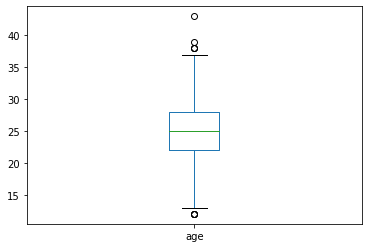

In [8]:
users['age'].plot(kind = 'box')
plt.show()

In [9]:
users.duplicated('user_id').sum()

31

In [10]:
users = users.drop_duplicates('user_id')
users.duplicated('user_id').sum()

0

В данном датафрейме было удалено 31 дубликата, пропущенных значений не обнаружено. Аномальных значений по возрасту так же не обнаружено.

In [11]:
rides['date'] = pd.to_datetime(rides['date'])
rides['month'] = rides['date'].dt.month
rides['duration'] = np.ceil(rides['duration']) 
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [12]:
rides.describe()

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,18.303520,6.486772
std,434.734317,1116.831209,6.094928,3.437410
min,1.000000,0.855683,1.000000,1.000000
25%,487.000000,2543.226360,14.000000,4.000000
50%,889.000000,3133.609994,18.000000,6.000000
75%,1213.250000,3776.222735,22.000000,9.000000
max,1534.000000,7211.007745,41.000000,12.000000


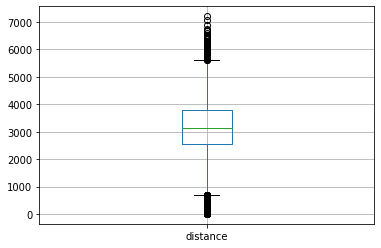

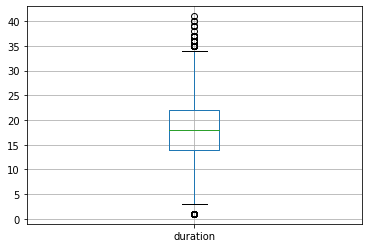

In [13]:
plt.figure()
rides.boxplot(column=['distance'])
plt.figure()
rides.boxplot(column = ['duration'])

plt.show()

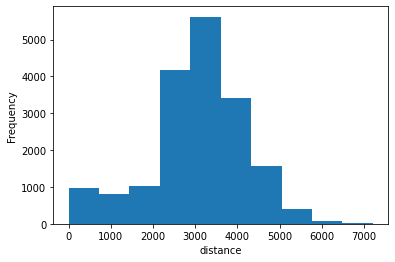

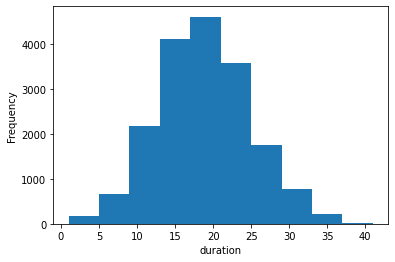

In [14]:
plt.figure()
rides['distance'].plot(kind ='hist')
plt.xlabel('distance')
plt.figure()
rides['duration'].plot(kind = 'hist')
plt.xlabel('duration')
plt.show()

In [15]:
(rides['distance'] <100).value_counts()


False    17990
True        78
Name: distance, dtype: int64

По данному датафрейму можно сделать вывод, что есть очевидно аномально низкие значения в duration. Предположительно пользователь по ошибке взял самокат(или передумал) Так как таких значений предельно мало, для точности дальнейших вычеслений можно ими пренебречь.

Так как датафрейм subscription обладает только двумя строками данных, его не рассматриваем и не меняем

**Вывод**

В ходе этой части были выполнены следующие пункты:
- Удалены дубликаты в датафрейме users
- Столбец date преобразован в тип datetime

#### Исследовательский анализ данных

##### Частота встречаемости городов

In [17]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

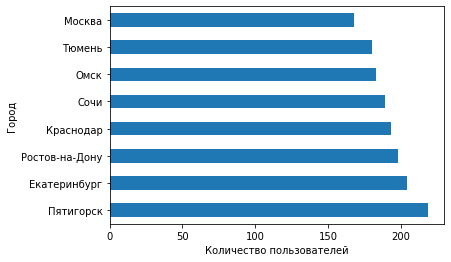

In [18]:
users['city'].value_counts().plot(kind = 'barh')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.show()

##### Соотношение пользователей с подпиской и без подписки

Соотношение пользователей с подпиской и без подписки равно: 0.4556714471968709
Процент пользователей с подпиской: 45.56714471968709


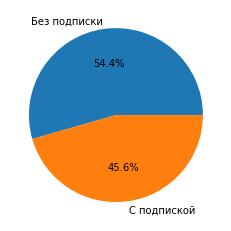

In [19]:
subscription_counts = users['subscription_type'].value_counts()
free_count = subscription_counts['free']
ultra_count = subscription_counts['ultra']

total_count = free_count + ultra_count
    
ratio = ultra_count / total_count
percentage = ratio * 100


print('Соотношение пользователей с подпиской и без подписки равно:', ratio)
print('Процент пользователей с подпиской:', percentage)

sizes = [free_count, ultra_count]
plt.pie(sizes, labels=['Без подписки', 'С подпиской'], autopct='%1.1f%%')

plt.show()

##### Возраст пользователей

In [20]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

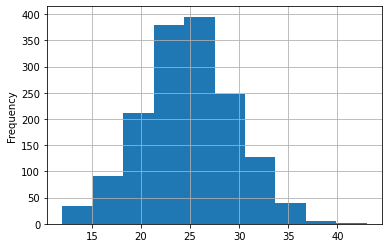

In [21]:
users['age'].plot(kind = 'hist', grid=True)
plt.show()

Возрастной контингент представлен в диапазоне от 12 до 43 лет, с средним значением 24.9 и стандартным отклонением в 4.6
Основные значения, которые находятся в диапазоне 1 и 3 квартиля составляют пользователи от 22 до 28 лет. Медианное значение находится на уровне 25 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

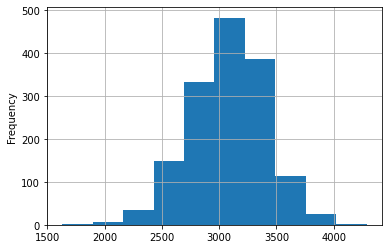

In [22]:
(rides
 .groupby('user_id')['distance']
 .mean()
 .plot(kind = 'hist',grid=True))
plt.show()

In [23]:
(rides
 .groupby('user_id')['distance']
 .mean()
 .describe())

count    1534.000000
mean     3077.296650
std       327.624403
min      1630.788427
25%      2882.505704
50%      3090.864050
75%      3293.325678
max      4287.519387
Name: distance, dtype: float64

Среднее расстояние каждого пользователя представлено в диапазоне от 1631 до 4288 метров, с средним значением 3087 метров и стандартным отклонением в 323.
Основные значения, которые находятся в диапазоне 1 и 3 квартиля составляют 2895 и 3302 соответственно. Медианное значение находится на уровне 3100 метров.

##### Продолжительность поездок

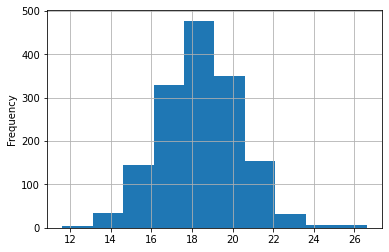

In [24]:
(rides
 .groupby('user_id')['duration']
 .mean()
 .plot(kind = 'hist',grid=True))
plt.show()

In [25]:
(rides
 .groupby('user_id')['duration']
 .mean()
 .describe())

count    1534.000000
mean       18.423613
std         1.973877
min        11.625000
25%        17.093182
50%        18.400000
75%        19.666667
max        26.600000
Name: duration, dtype: float64

Среднее время маршрута каждого пользователя представлено в диапазоне от 12 до 27 минут, с средним значением 18 и стандартным отклонением в 2. Основные значения, которые находятся в диапазоне 1 и 3 квартиля составляют 17 и 20 соответственно. Медианное значение находится на уровне 18 минут.



**Вывод**

Из данных полученых в данном пункте можно сделать следующие выводы:
- Больше всего стречаются пользователи из Пятигорска, меньше всего в Москве (219 и 168 соответственно)
- Пользователей с подпиской меньше, чем без нее (соотношение 0.84)
- Основная целевая аудитори компании, молодые люди в возрасте от 22 до 28 лет
- В среднем пользователи совершают поездки на расстояние 3087 метров
- Средняя поездка занимает около 18 минут

#### Объединение данных

##### Создание датафрейма full_data

In [26]:
full_data = (users
             .merge(rides, on = 'user_id')
             .merge(subscription, on = 'subscription_type'))
full_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [27]:
#Удостоверимся, что все столбцы присутствуют и пропущенных значений не появилось
full_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

##### Создание датафреймов по подписке и без

In [28]:
df_w_subs = full_data[full_data['subscription_type'] == 'ultra']
df_wout_subs = full_data[full_data['subscription_type'] == 'free']

df_w_subs['subscription_type'].value_counts()

ultra    6500
Name: subscription_type, dtype: int64

In [29]:
df_wout_subs['subscription_type'].value_counts()

free    11568
Name: subscription_type, dtype: int64

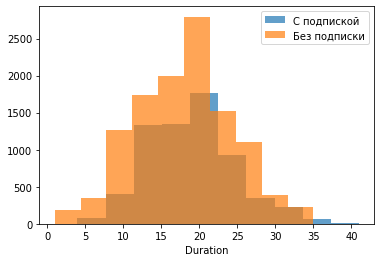

In [30]:
plt.hist(df_w_subs['duration'], alpha = 0.7, label = 'С подпиской')
plt.hist(df_wout_subs['duration'], alpha = 0.7, label = 'Без подписки')

plt.xlabel('Duration')
plt.legend()

plt.show()

In [31]:
print(df_w_subs['duration'].describe())
df_wout_subs['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64


count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

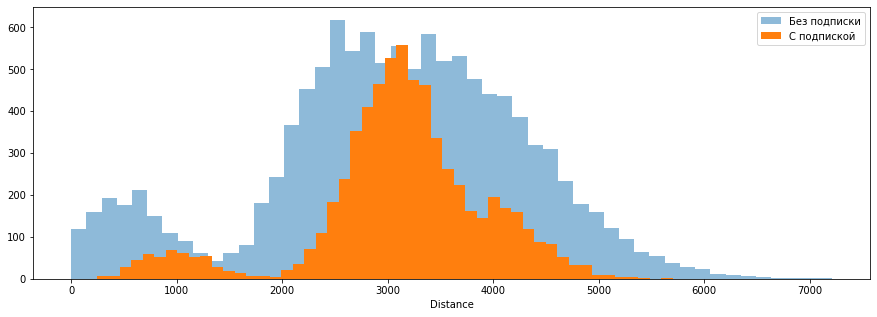

In [44]:
plt.figure(figsize = (15, 5))
plt.hist(df_wout_subs['distance'], alpha = 0.5, label = 'Без подписки', bins = 50)
plt.hist(df_w_subs['distance'], label = 'С подпиской', bins= 50)

plt.xlabel('Distance')
plt.legend()

plt.show()

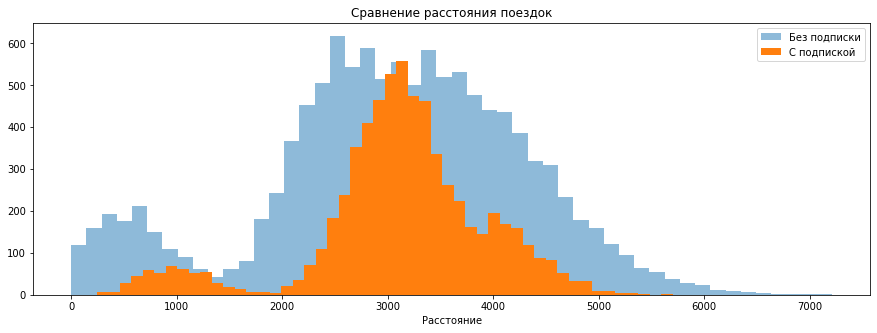

In [33]:
# Код ревьюера
plt.figure(figsize = (15, 5))
plt.hist(df_wout_subs['distance'], alpha = 0.5, label = 'Без подписки', bins = 50)
plt.hist(df_w_subs['distance'], label = 'С подпиской', bins = 50)


plt.xlabel('Расстояние')
plt.title('Сравнение расстояния поездок')
plt.legend()

plt.show()

In [34]:
print(df_wout_subs['distance'].describe())
df_w_subs['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

**Вывод**

В ходе данной части были проделаны следующие шаги:
- Объеденены датафреймы в один общий
- Созданы датафреймы по категориям подписки
- Рассмотрена информация о времени поездок и их расстоянии для каждой категории
    - В среднем пользователи с подпиской проводят в пути 19 минут, в то время как пользователи без подписки 18 минут.
    - Расстояние, которое в среднем преодолевают пользователи с подпиской равно 3115 метров, а без подписки 3045 метров.
    - Графики визуально показывают, что пользователей без подписки больше чем с подпиской
    - Можно заметить, что в двух случаях выборка стремится к нормальному распределению и в целом повторяют друг друга. Однако стоит заметить следующее:
        - Значение длительности поездки смещено вправо для пользователей с подпиской относительно пользователей без подписки, это может быть обусловлено разной стоимости минуты аренды

#### Подсчёт выручки

##### Создание датафрейма с агрегированными данными

In [35]:
df_agg = (full_data
          .groupby(['user_id', 'month','minute_price',
                    'start_ride_price','subscription_fee',
                    'subscription_type'])
          .agg({'distance': 'sum',
                'duration': ['count', 'sum']}))

df_agg.columns = ['total_distance', 'count_trips', 'total_duration']
df_agg.reset_index(inplace = True)


df_agg.head(10)

,user_id,month,minute_price,start_ride_price,subscription_fee,subscription_type,total_distance,count_trips,total_duration
0,1,1,6,0,199,ultra,7027.511294,2,42.0
1,1,4,6,0,199,ultra,754.159807,1,7.0
2,1,8,6,0,199,ultra,6723.470560,2,46.0
3,1,10,6,0,199,ultra,5809.911100,2,32.0
4,1,11,6,0,199,ultra,7003.499363,3,56.0
5,1,12,6,0,199,ultra,6751.629942,2,28.0
6,2,3,6,0,199,ultra,10187.723006,3,63.0
7,2,4,6,0,199,ultra,6164.381824,2,40.0
8,2,6,6,0,199,ultra,3255.338202,1,14.0
9,2,7,6,0,199,ultra,6780.722964,2,48.0


##### Подсчет выручки

In [36]:
df_agg['revenue'] = ((df_agg['start_ride_price'] * df_agg['count_trips'])
                     + 
                     (df_agg['minute_price'] * df_agg['total_duration']) 
                     + 
                     df_agg['subscription_fee'])
df_agg.head()

,user_id,month,minute_price,start_ride_price,subscription_fee,subscription_type,total_distance,count_trips,total_duration,revenue
0,1,1,6,0,199,ultra,7027.511294,2,42.0,451.0
1,1,4,6,0,199,ultra,754.159807,1,7.0,241.0
2,1,8,6,0,199,ultra,6723.470560,2,46.0,475.0
3,1,10,6,0,199,ultra,5809.911100,2,32.0,391.0
4,1,11,6,0,199,ultra,7003.499363,3,56.0,535.0


In [37]:
# Код ревьюера
df_agg.groupby('subscription_type')['revenue'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: revenue, dtype: float64

####  Проверка гипотез
Для всех гипотез будем использовать значение альфа = 0.05

##### Гипотеза 1: 
- H0 - Среднее время поездок не отличается
- H1 - Среднее время поездок пользователей с подпиской больше, чем среднее время поездок пользователей без подписки

In [38]:
t_statistic, p_value = (st
                        .ttest_ind(df_w_subs['duration'],
                                   df_wout_subs['duration'], 
                                   alternative='greater'))
print('p_value:',p_value, 't_statistic:',t_statistic)

p_value: 2.4959453720736625e-34 t_statistic: 12.186464491247767


Вывод: Отвергаем нулевую гипотезу в пользу альтернативной, так как p-value является крайне малым, а значение t-statistics имеет высокое значение.
**Пользователи с подпиской тратят статестически значимо больше времени на поездки, чем пользователи без подписки**

##### Гипотеза 2:
- H0 - Среднее расстояние поездки пользователей с подпиской меньше или равно 3130 метров 
- H1 - Среднее расстояние поездки пользователей с подпиской больше 3130 метров

In [39]:
interested_value = 3130
t_statistic, p_value = (st
                        .ttest_1samp(df_w_subs['distance'],
                                   interested_value, 
                                   alternative='greater'))
print('p_value:',p_value, 't_statistic:',t_statistic)

p_value: 0.9195368847849785 t_statistic: -1.402123166869486


По значениям, которые мы получили, мы не можем опровергнуть нулевую гипотезу, следовательно статистически **Среднее расстояние поездки пользователей с подпиской меньше или равно 3130 метров**

##### Гипотеза 3:
- H0 - Средняя помесячная выручка от пользователей с подпиской и без не отличаются
- H1 - Средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки

In [40]:
revenue_subs = df_agg[df_agg['subscription_type'] == 'ultra']['revenue']
revenue_wout_subs = df_agg[df_agg['subscription_type'] == 'free']['revenue']

t_statistic, p_value = (st
                        .ttest_ind(revenue_subs,
                                   revenue_wout_subs, 
                                   alternative='greater'))
print('p_value:',p_value, 't_statistic:',t_statistic)

p_value: 1.8850394384715216e-31 t_statistic: 11.64246602360774


На основе данных можно опровергнуть нулевую гипотезу в пользу альтернативной. **Средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки**

##### Поиск оптимального теста:
Так как оба набора данных являются связанными для одной и той же выборки (пользователь остается неизменным), можно использовать парный тест. Гипотеза будет двусторонноей и можно ее обозначить таким образом:
- H0 - Среднее количество обращений в техподдержку до и после обновления серверов не отличается
- H1 - Среднее количество обращений в техподдержку после обновления серверов меньше, чем до обновления

#### Общий вывод:

В данной работе были проведены следующие задания:
-  В ходе предобработки данных, были изменены типы данных, удалены дубликаты и аномальные значения
-  Исследованы значения в датафреймах, а именно:
    - была проанализированна частота встречаемости городов(на первом месте Пятигорск - 219, на последнем Москва - 168);
    - было определено соотношение пользователей с подпиской и без подписки(45.6% и 54.4% соответственно);
    - был проанализирован возраст пользователей(ЦА от 22 до 28 лет);
    - было найдено расстояние, которое пользователь преодолел за одну поездку(в среднем 3087 метров);
    - продолжительность поездок была рассчитана(среднее значение около 18 минут).
- Данные из трех датафреймов были объеденены
- Созданы два новых датафрейма, в которых была визуализирована информация о расстоянии и времени поездок для пользователей с подпиской и без подписки.
- Был создан новый датафрейм, в котором содержится агрегированная информация о поездках для каждого пользователя за месяц, включая суммарное расстояние, количество поездок, суммарное время и выручку каждого пользователя.
- Были проверены следующие гипотезы:
    - Влияние подписки на время поездки (Пользователи с подпиской тратят статестически значимо больше времени на поездки, чем пользователи без подписки)
    - Является ли расстояние одной поездки в 3130 метров оптимальным с точки зрения износа самоката? (Среднее расстояние поездки пользователей с подпиской меньше или равно 3130 метров)
    - Выше ли помесячная выручка пользователей за месяц, относительно пользователей без подписки? (Средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки)
        - Для проверки гипотезы о снижении обращений в техподдержку после обновления серверов был рекомендован парный тест
        
**По данным можно сделать главный вывод, что пользователи с подпиской приносят больше выручки, оптимально используют ресурс самоката(для заданных компанией значений), нежели пользователи без подписки, однако не стоит отрицать тот факт, что таких пользователей меньше и делать упор только на них**